In [1]:
from dipy.core.gradients import gradient_table
from dipy.data import default_sphere, get_fnames
from dipy.direction import peaks_from_model
from dipy.io.image import load_nifti, load_nifti_data
from dipy.io.gradients import read_bvals_bvecs
from dipy.reconst.shm import CsaOdfModel
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines, cluster_confidence
from dipy.tracking.utils import length
from dipy.viz import actor, window

import matplotlib.pyplot as plt

In [2]:
hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
label_fname = get_fnames('stanford_labels')

data, affine = load_nifti(hardi_fname)
labels = load_nifti_data(label_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

white_matter = (labels == 1) | (labels == 2)
csa_model = CsaOdfModel(gtab, sh_order=6)
csa_peaks = peaks_from_model(csa_model, data, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=white_matter)
stopping_criterion = ThresholdStoppingCriterion(csa_peaks.gfa, .25)

Download Progress: [########################################] 100.00%  of 0.00 MBB

In [3]:
# Make a corpus callosum seed mask for tracking
seed_mask = labels == 2
seeds = utils.seeds_from_mask(seed_mask, affine, density=[1, 1, 1])
# Make a streamline bundle model of the corpus callosum ROI connectivity
streamlines = LocalTracking(csa_peaks, stopping_criterion, seeds, affine,
                            step_size=2)
streamlines = Streamlines(streamlines)

In [4]:
lengths = list(length(streamlines))
long_streamlines = Streamlines()
for i, sl in enumerate(streamlines):
    if lengths[i] > 40:
        long_streamlines.append(sl)

In [6]:
cci = cluster_confidence(long_streamlines)

# Visualize the streamlines, colored by cci
ren = window.Renderer()

hue = [0.5, 1]
saturation = [0.0, 1.0]

lut_cmap = actor.colormap_lookup_table(scale_range=(cci.min(), cci.max()/4),
                                       hue_range=hue,
                                       saturation_range=saturation)

bar3 = actor.scalar_bar(lut_cmap)
ren.add(bar3)

stream_actor = actor.line(long_streamlines, cci, linewidth=0.1,
                          lookup_colormap=lut_cmap)
ren.add(stream_actor)

In [8]:
interactive = True
if interactive:
    window.show(ren)
window.record(ren, n_frames=1, out_path='cci_streamlines.png',
              size=(800, 800))

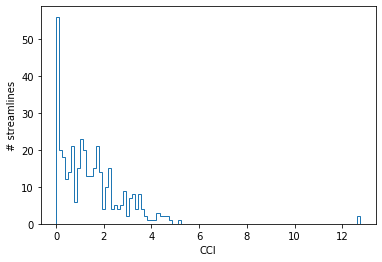

In [9]:
fig, ax = plt.subplots(1)
ax.hist(cci, bins=100, histtype='step')
ax.set_xlabel('CCI')
ax.set_ylabel('# streamlines')
fig.savefig('cci_histogram.png')

In [10]:
keep_streamlines = Streamlines()
for i, sl in enumerate(long_streamlines):
    if cci[i] >= 1:
        keep_streamlines.append(sl)

# Visualize the streamlines we kept
ren = window.Renderer()

keep_streamlines_actor = actor.line(keep_streamlines, linewidth=0.1)

ren.add(keep_streamlines_actor)


interactive = True
if interactive:
    window.show(ren)
window.record(ren, n_frames=1, out_path='filtered_cci_streamlines.png',
              size=(800, 800))